In [1]:
import json, re
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

from vllm import LLM, SamplingParams
from collections import defaultdict
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 05-14 06:33:57 [__init__.py:239] Automatically detected platform cuda.


2025-05-14 06:33:58,499	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Compute score

In [2]:
def extract_numbers_and_target(prompt):
    numbers_match = re.search(r'\[(\d+(?:,\s*\d+)*)\]', prompt)
    numbers = list(map(int, numbers_match.group(1).split(','))) if numbers_match else []

    # Extract the target number
    target_match = re.search(r'equals\s+(\d+)', prompt)
    target = int(target_match.group(1)) if target_match else None
    return numbers, target


def extract_solution(solution_str):
    """Extract the equation from the solution string."""
    # # Remove everything before the first "Assistant:"
    # if "Assistant:" in solution_str:
    #     solution_str = solution_str.split("Assistant:", 1)[1]
    # elif "<|im_start|>assistant" in solution_str:
    #     solution_str = solution_str.split("<|im_start|>assistant", 1)[1]
    # else:
    #     return None
    solution_str = solution_str.split('\n')[-1]

    answer_pattern = r'(.*?)</answer>'
    match = re.finditer(answer_pattern, solution_str)
    matches = list(match)
    if matches:
        final_answer = matches[-1].group(1).strip()
    else:
        final_answer = None
    return final_answer


def validate_equation(equation_str, available_numbers):
    """Validate that equation only uses available numbers and each number once."""
    try:
        # Extract all numbers from the equation
        numbers_in_eq = [int(n) for n in re.findall(r'\d+', equation_str)]
        
        # Check if all numbers in equation are available
        available_numbers = sorted(available_numbers)
        numbers_in_eq = sorted(numbers_in_eq)
        
        # Each number should be used exactly once
        return numbers_in_eq == available_numbers
    except:
        return False


def evaluate_equation(equation_str):
    """Safely evaluate the arithmetic equation using eval() with precautions."""
    try:
        # Define a regex pattern that only allows numbers, operators, parentheses, and whitespace
        allowed_pattern = r'^[\d+\-*/().\s]+$'
        if not re.match(allowed_pattern, equation_str):
            raise ValueError("Invalid characters in equation.")

        # Evaluate the equation with restricted globals and locals
        result = eval(equation_str, {"__builtins__": None}, {})
        return result
    except Exception as e:
        return None


def compute_score(input_str, solution_str, format_score=0, score=1):
    """The scoring function for countdown task.
    
    Args:
        solution_str: the solution text
        ground_truth: dictionary containing target number and available numbers
        method: the method to extract the solution
        format_score: the score for correct format but wrong answer
        score: the score for the correct answer
    """
    numbers, target = extract_numbers_and_target(input_str)
    equation = extract_solution(solution_str=solution_str)
    do_print = False

    if equation is None:
        if do_print:
            print(f"No equation found")
        return 0
    
    # Validate equation uses correct numbers
    if not validate_equation(equation, numbers):
        if do_print:
            print(f"Invalid equation")
        return format_score
        
    # Evaluate equation
    try:
        result = evaluate_equation(equation)
        if result is None:
            if do_print:
                print(f"Could not evaluate equation")
            return format_score
            
        if abs(result - target) < 1e-5:  # Account for floating point precision
            if do_print:
                print(f"Correct equation: {equation} = {result}")
            return score
        else:
            if do_print:
                print(f"Wrong result: equation = {result}, target = {target}")
            return format_score
    except:
        if do_print:
            print(f"Error evaluating equation")
        return format_score 

### Load model and generate rollouts

In [3]:
llm = LLM(model="/home/cmu/countdown-curriculum/checkpoints/normal/global_step_60/hf")
# llm = LLM(model="d1shs0ap/cognitive-behaviors-Llama-3.2-3B")

INFO 05-14 06:34:06 [config.py:689] This model supports multiple tasks: {'generate', 'score', 'classify', 'embed', 'reward'}. Defaulting to 'generate'.
INFO 05-14 06:34:06 [config.py:1901] Chunked prefill is enabled with max_num_batched_tokens=16384.
INFO 05-14 06:34:08 [core.py:61] Initializing a V1 LLM engine (v0.8.4) with config: model='/home/cmu/countdown-curriculum/checkpoints/normal/global_step_60/hf', speculative_config=None, tokenizer='/home/cmu/countdown-curriculum/checkpoints/normal/global_step_60/hf', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=131072, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.44it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.58it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.56it/s]



INFO 05-14 06:34:13 [loader.py:458] Loading weights took 1.36 seconds
INFO 05-14 06:34:13 [gpu_model_runner.py:1291] Model loading took 6.0160 GiB and 1.559889 seconds
INFO 05-14 06:34:19 [backends.py:416] Using cache directory: /home/cmu/.cache/vllm/torch_compile_cache/af891837cd/rank_0_0 for vLLM's torch.compile
INFO 05-14 06:34:19 [backends.py:426] Dynamo bytecode transform time: 5.98 s
INFO 05-14 06:34:21 [backends.py:132] Cache the graph of shape None for later use
INFO 05-14 06:34:40 [backends.py:144] Compiling a graph for general shape takes 20.93 s
INFO 05-14 06:34:51 [monitor.py:33] torch.compile takes 26.91 s in total
INFO 05-14 06:34:52 [kv_cache_utils.py:634] GPU KV cache size: 559,264 tokens
INFO 05-14 06:34:52 [kv_cache_utils.py:637] Maximum concurrency for 131,072 tokens per request: 4.27x
INFO 05-14 06:35:11 [gpu_model_runner.py:1626] Graph capturing finished in 19 secs, took 0.58 GiB
INFO 05-14 06:35:11 [core.py:163] init engine (profile, create kv cache, warmup model)

In [4]:
with open('/home/cmu/countdown-curriculum/checkpoints/normal/60_rollouts.json', 'r') as f:
    rollouts = json.load(f)

### Visualize # of attempts

In [5]:
attempts = []
for rollout in rollouts:
    if rollout['ref_score'] != 5:
        continue
    attempts.append(len(rollout['output'].split('\n\n')))

<Axes: ylabel='Count'>

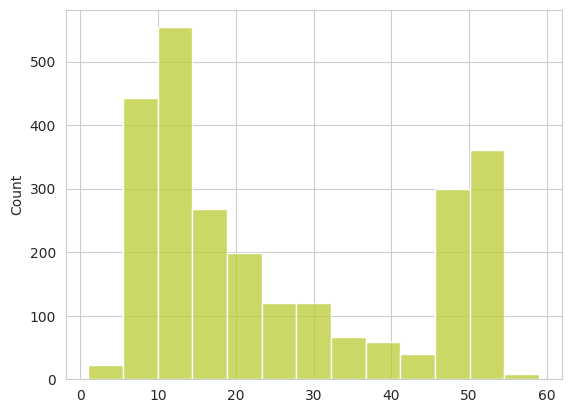

In [6]:
sns.histplot(attempts)

### Rollout and compute pass@1

In [7]:
def compute_pass_at_k(n, c, k):
    if n - c < k:
        return 1.0
    
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

In [8]:
def extract_equations(attempt):
    equation_line_pattern = re.compile(r'^([\d\s\+\-\*/=]+)')

    equations = []
    for line in attempt.strip().split('\n'):
        line = line.strip()
        match = equation_line_pattern.match(line)
        if match:
            cleaned_eq = match.group(1).strip()
            equations.append(cleaned_eq)
        elif any(op in line for op in '+-*/='):  # fallback: manually extract left side before any annotation
            cleaned_eq = re.split(r'\s*\(.*?\)', line)[0].strip()
            equations.append(cleaned_eq)

    return equations

In [9]:
attempts_to_k_to_pass_at_k = defaultdict(lambda: defaultdict(list))
R = 8

for attempts_budget_per_rollout in [2, 4, 8, 16]:
    
    for p in tqdm(range(len(rollouts) // 8)):
        if rollouts[8 * p]['ref_score'] != 5:
            continue
        
        n = 8 * R
        c = 0
        prefixes = []
        
        for i in range(8):
            problem = rollouts[8 * p + i]
            attempts = problem['output'].split('</think>')[0].split('\n\n')

            attempts_used = 0
            budget_index = len(attempts)
            for l, attempt in enumerate(attempts):
                if len(extract_equations(attempt)) > 0:
                    attempts_used += 1
                    if attempts_used == attempts_budget_per_rollout:
                        budget_index = l + 1
                        break
            
            prefixes.append(problem['input'] + '\n\n'.join(attempts[:budget_index]) + "\n</think>\n<answer>")
        
        completions = llm.generate(prompts=prefixes, sampling_params=SamplingParams(n=R, temperature=0.6, top_p=0.95, max_tokens=32), use_tqdm=False)
        for completion in completions:
            for output in completion.outputs:
                c += compute_score(problem['input'], output.text, format_score=0, score=1)
                
        
        for k in [1, 2, 4, 8, 16]:
            attempts_to_k_to_pass_at_k[attempts_budget_per_rollout][k].append(compute_pass_at_k(n, c, k))


100%|██████████| 640/640 [01:17<00:00,  8.30it/s]


In [10]:
for attempts_budget_per_rollout in [2, 4, 8, 16]:
    for k in [1, 2, 4, 8, 16]:
        pass_at_k = np.mean(attempts_to_k_to_pass_at_k[attempts_budget_per_rollout][k])
        attempts_to_k_to_pass_at_k[attempts_budget_per_rollout][k] = pass_at_k
        print(f"pass@{k} at {attempts_budget_per_rollout} attempts: {pass_at_k:.4f}")

pass@1 at 2 attempts: 0.0105
pass@2 at 2 attempts: 0.0199
pass@4 at 2 attempts: 0.0360
pass@8 at 2 attempts: 0.0604
pass@16 at 2 attempts: 0.0923
pass@1 at 4 attempts: 0.0521
pass@2 at 4 attempts: 0.0890
pass@4 at 4 attempts: 0.1412
pass@8 at 4 attempts: 0.2055
pass@16 at 4 attempts: 0.2693
pass@1 at 8 attempts: 0.1944
pass@2 at 8 attempts: 0.2778
pass@4 at 8 attempts: 0.3590
pass@8 at 8 attempts: 0.4251
pass@16 at 8 attempts: 0.4673
pass@1 at 16 attempts: 0.4665
pass@2 at 16 attempts: 0.5521
pass@4 at 16 attempts: 0.6193
pass@8 at 16 attempts: 0.6665
pass@16 at 16 attempts: 0.6950


In [11]:
save_dict = {}
for attempts_budget_per_rollout in [2, 4, 8, 16]:
    save_dict[attempts_budget_per_rollout] = dict(attempts_to_k_to_pass_at_k[attempts_budget_per_rollout])

with open('attempts_to_k_to_pass_at_k_60.pkl', 'wb') as f:
    pickle.dump(save_dict, f)

### Plot

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")
import pickle

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

In [6]:
with open('attempts_to_k_to_pass_at_k_0.pkl', 'rb') as f:
    attempts_to_k_to_pass_at_k = pickle.load(f)

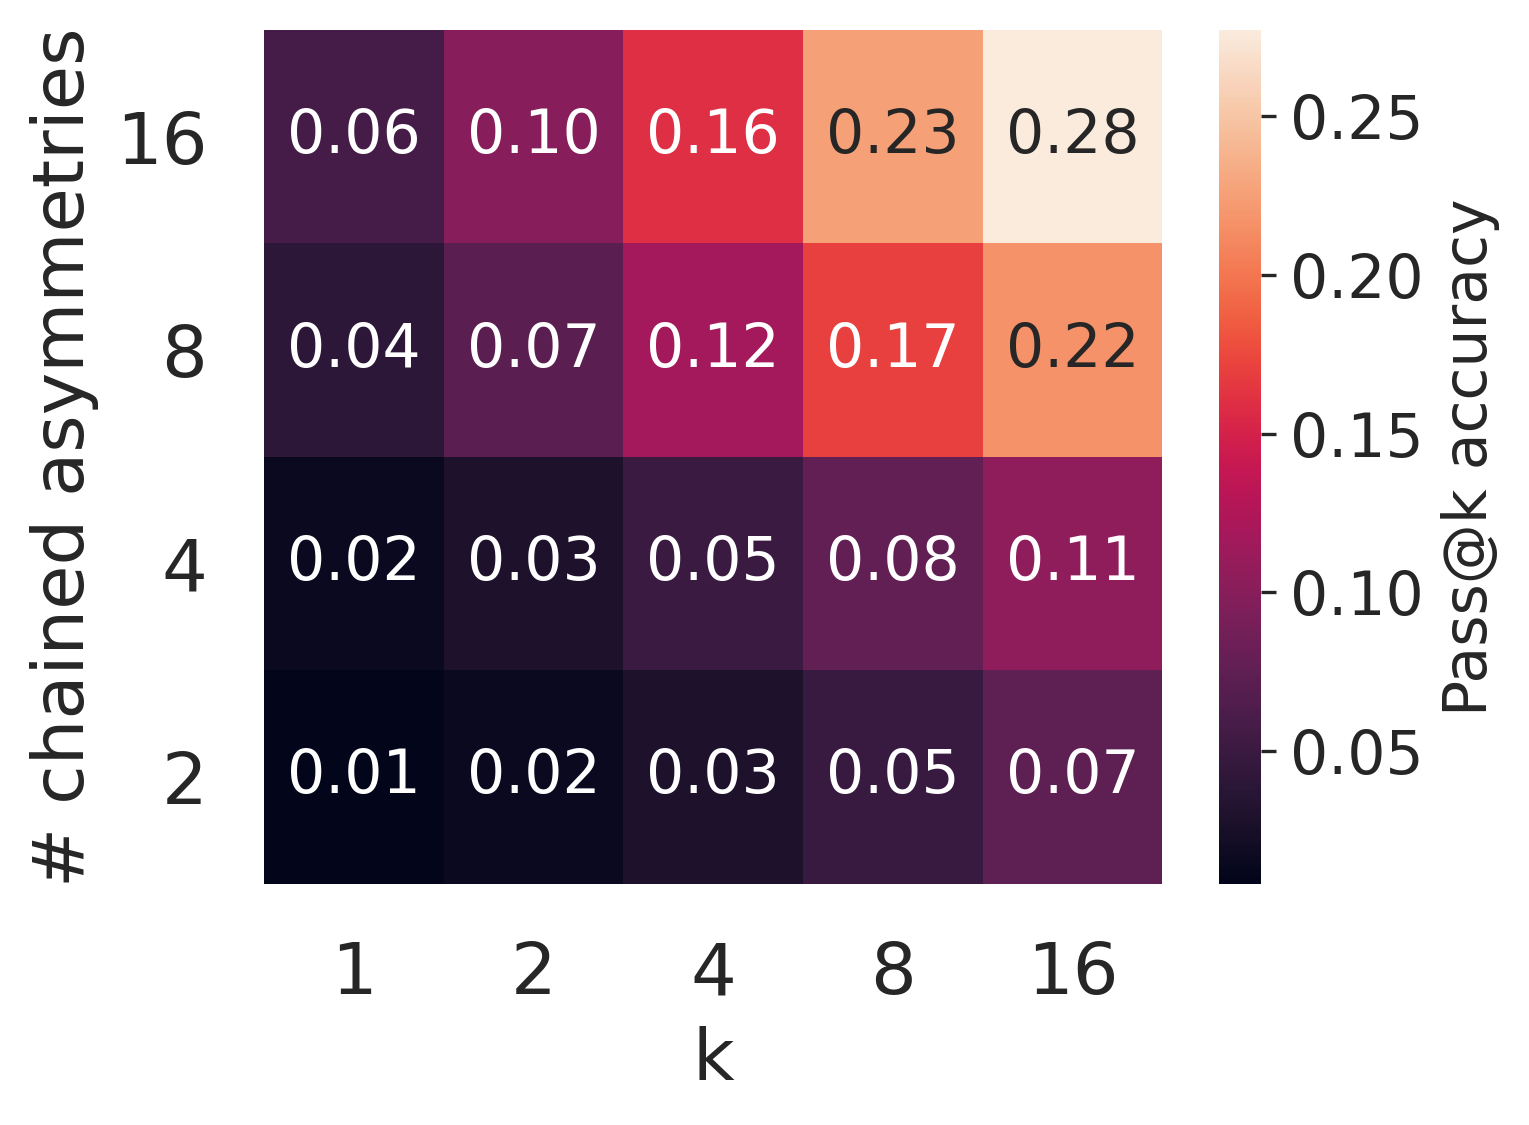

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300)
fig.set_size_inches(496.0/192*2, 369.6/192*2)

# Dummy data structure: value[attempts_budget_per_rollout][k]
value = {
    2: {1: 0.1, 2: 0.2, 4: 0.3, 8: 0.4},
    4: {1: 0.15, 2: 0.25, 4: 0.35, 8: 0.45},
    8: {1: 0.2, 2: 0.3, 4: 0.4, 8: 0.5},
    16: {1: 0.25, 2: 0.35, 4: 0.45, 8: 0.55}
}

# Convert the nested dict into a DataFrame
df = pd.DataFrame(attempts_to_k_to_pass_at_k).T  # .T to make attempts_budget_per_rollout the index (y-axis)
df = df.sort_index(ascending=False)         # ensure y-axis is sorted


# Plot using seaborn heatmap
sns.heatmap(df, annot=True, fmt=".2f", annot_kws={'size': 'x-large'}, cbar_kws={'label': 'pass@k accuracy'}, ax=ax) # , vmin=0.01, vmax=0.69, cbar=False

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize='x-large')
cbar.set_label("Pass@k accuracy", size='x-large')

plot_utils._annotate_and_decorate_axis(ax,
                                        xlabel=r'k',
                                        ylabel=r'# chained asymmetries',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=False)

# plt.title("Temperature Map")
plt.tight_layout()

plt.savefig("plots/asymmetry_gap_0.pdf", bbox_inches='tight',pad_inches=0)
plt.show()

### Legacy plots

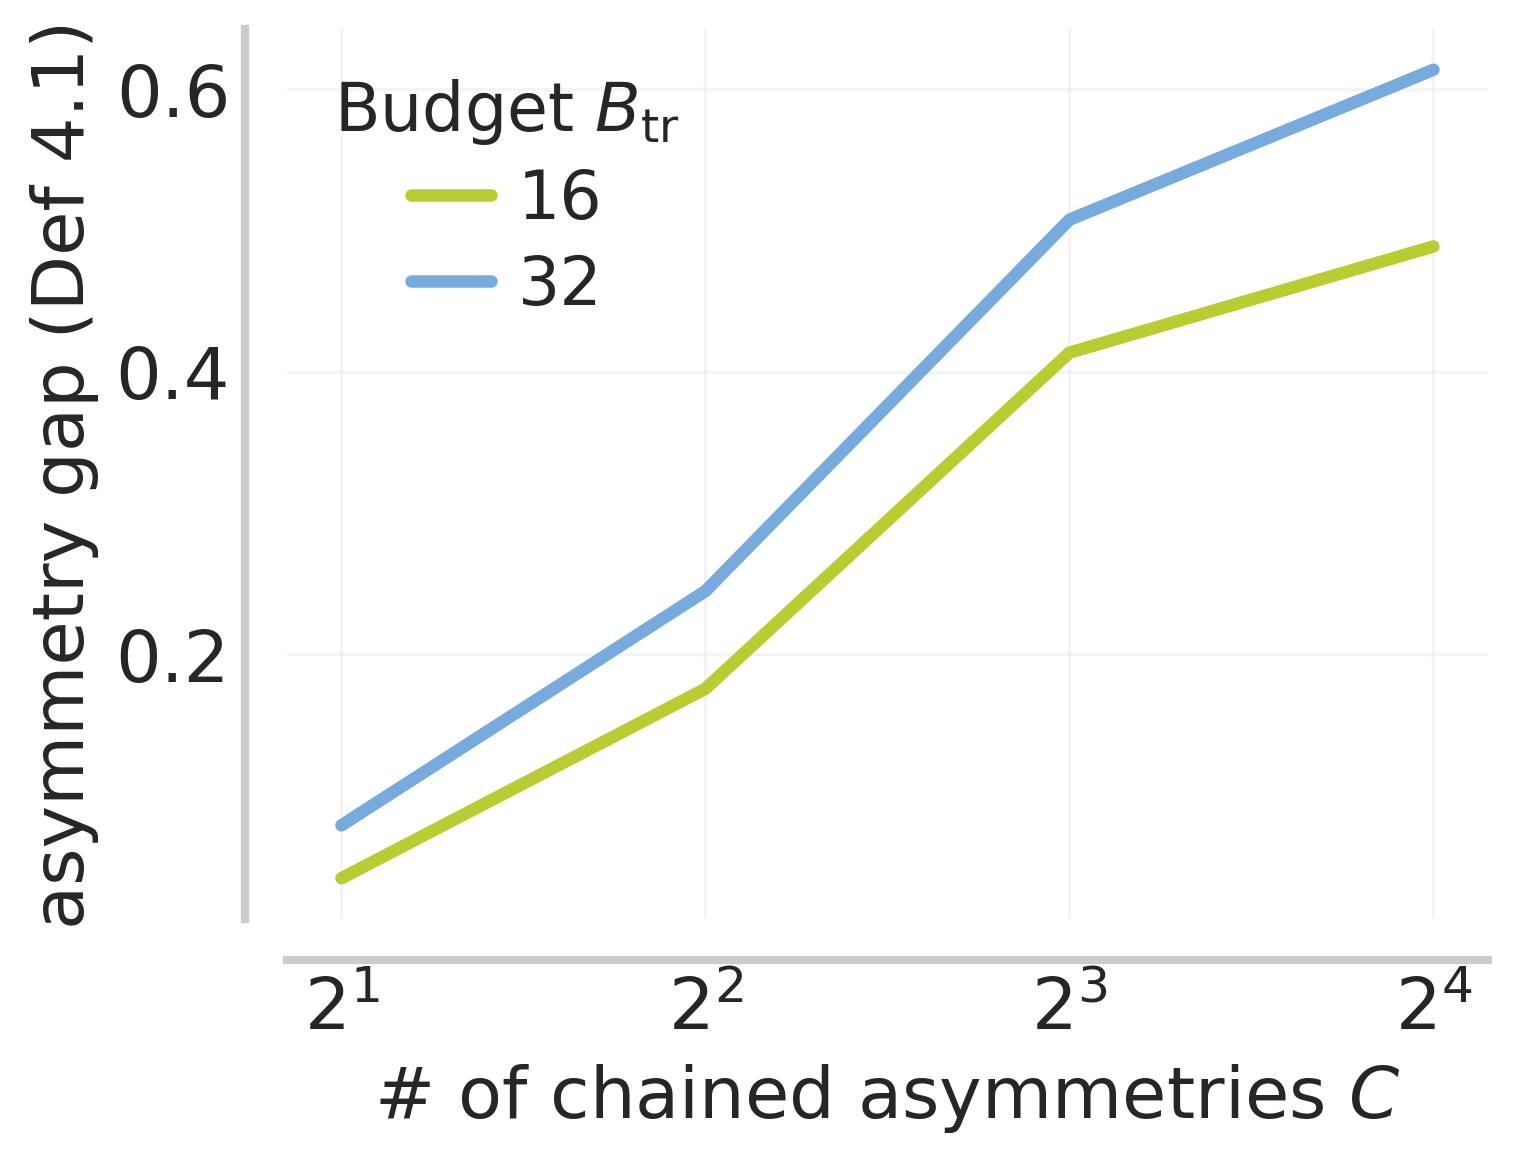

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300)
fig.set_size_inches(496.0/192*2, 369.6/192*2)


for attempts_budget_per_rollout in [2, 4, 8, 16]:
    for k in [1, 2, 4, 8, 16]:
        pass_at_k = np.mean(attempts_to_k_to_pass_at_k[attempts_budget_per_rollout][k])
        print(f"pass@{k} at {attempts_budget_per_rollout} attempts: {pass_at_k:.4f}")
    

    
    sns.lineplot(x=[1, 2, 3, 4], y=pass_at_k, ax=ax, linewidth=3, markersize=8, color=COLORS[i], label=f'{B}', linestyle='-')

plt.xticks(ticks=[i for i in range(1, 5)], labels=[f"$2^{{{i}}}$" for i in range(1, 5)])

plot_utils._annotate_and_decorate_axis(ax,
                                        xlabel=r'# of chained asymmetries $C$',
                                        # ylabel=r'pass@($B/C$)',
                                        ylabel=r'asymmetry gap (Def 4.1)',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)

ax.legend(
        title=r"Budget $B_\mathrm{tr}$",
        title_fontsize=16,          # Title font size
        prop={'size': 16},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper left",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

plt.savefig("plots/asymmetry_gap.pdf", bbox_inches='tight',pad_inches=0)
plt.show()